In [16]:
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
#settings
import warnings
warnings.filterwarnings("ignore")


In [2]:
sales = pd.read_csv("../../data/sales_train.csv")

item_cat = pd.read_csv("../../data/item_categories.csv")
item = pd.read_csv("../../data/items.csv")
sub = pd.read_csv("../../data/sample_submission.csv")
shops = pd.read_csv("../../data/shops.csv")
test = pd.read_csv("../../data/test.csv")


In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))


In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])[
                "date", "item_price", "item_cnt_day"].agg({"date":["min", "max"],
                                        "item_price": "mean", "item_cnt_day": "sum"})


In [7]:
monthly_sales

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

In [8]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.iloc[0:10].reset_index()


In [9]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


In [10]:
item

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


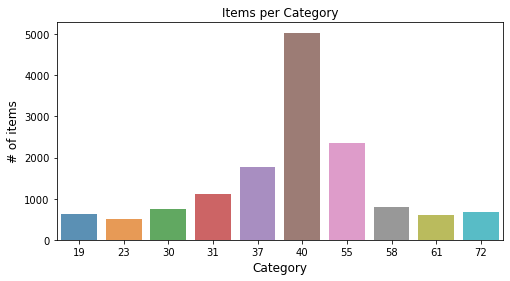

In [11]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()


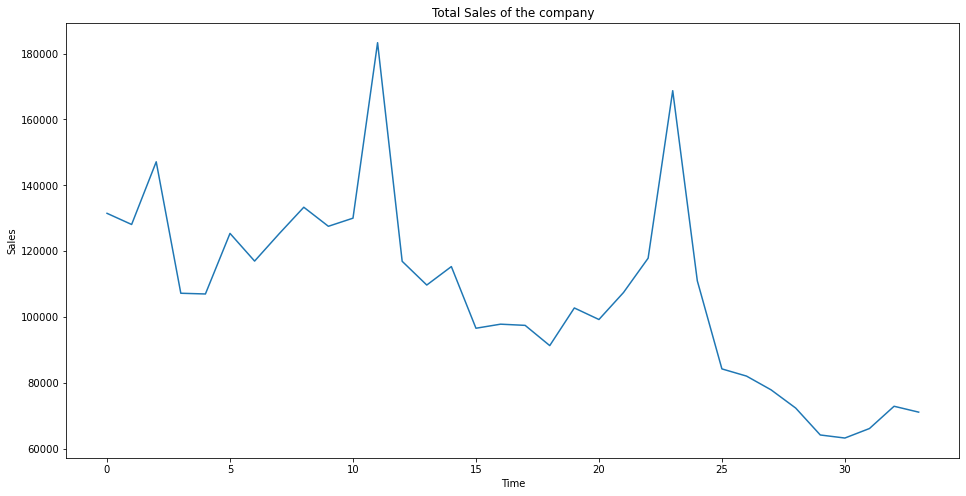

In [12]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16, 8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)


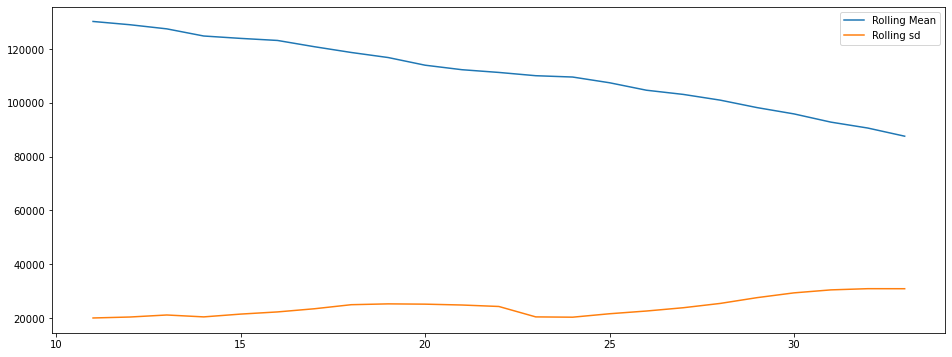

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean');
plt.plot(ts.rolling(window=12, center=False).std(), label="Rolling sd");
plt.legend();


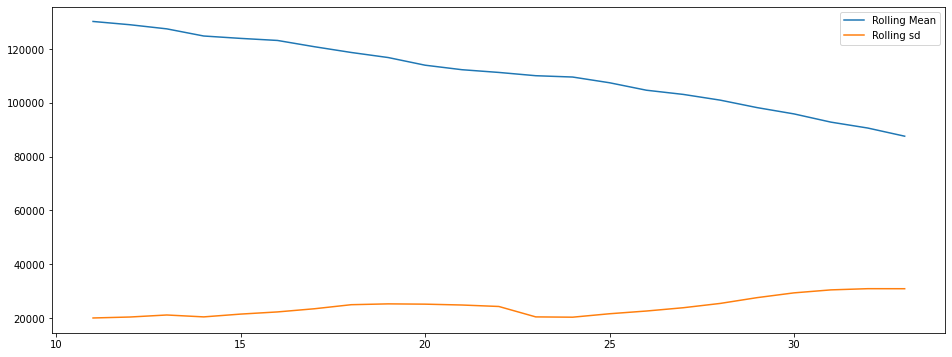

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window=12, center=False).std(), label="Rolling sd")
plt.legend()


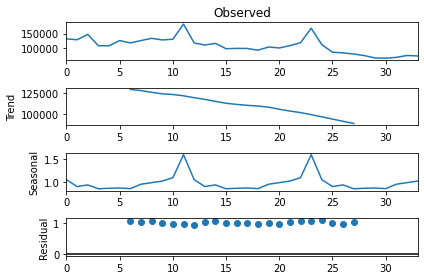

In [18]:
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
fig = res.plot()

